# Notebook 3 (v2) — Model-free Bounds via Super/Sub-Hedging (robust solvers)

This version fixes the `NoneType` error by **checking the solver status**.  
If CVXPY doesn't return an optimal solution, we **fall back to SciPy** automatically.

In [41]:
# %pip install numpy pandas scipy matplotlib cvxpy yfinance nbformat
import numpy as np, pandas as pd, numpy.linalg as LA, matplotlib.pyplot as plt, math, warnings, json
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda v: f'{v:,.6f}')

try:
    import yfinance as yf; HAVE_YF=True
except Exception:
    HAVE_YF=False

try:
    import cvxpy as cp; HAVE_CVXPY=True
except Exception:
    HAVE_CVXPY=False

from scipy import optimize
from pathlib import Path
DATA_DIR = Path('C:/Pcs/Python/new price project')
CLEANED_PATH = DATA_DIR / 'cleaned_chain_v2.csv'
SAMPLE_CHAIN = DATA_DIR / 'sample_chain.csv'

In [42]:
# Ensure a small sample chain exists so the notebook always runs
import datetime as dt, math, numpy as np, pandas as pd
if not SAMPLE_CHAIN.exists():
    def bs_call_price(S, K, r, q, sigma, T):
        if T <= 0 or sigma <= 0 or S <= 0 or K <= 0:
            return max(S*math.exp(-q*T) - K*math.exp(-r*T), 0.0)
        d1 = (math.log(S/K) + (r - q + 0.5*sigma**2)*T)/(sigma*math.sqrt(T))
        d2 = d1 - sigma*math.sqrt(T)
        from math import erf, sqrt
        N = lambda x: 0.5*(1.0+erf(x/sqrt(2.0)))
        return S*math.exp(-q*T)*N(d1) - K*math.exp(-r*T)*N(d2)
    S0 = 450.0; r=0.03; q=0.01; sigma=0.22; T=30/365.0
    Ks = np.arange(225.0, 680.0, 5.0)
    call_mid = np.array([bs_call_price(S0,K,r,q,sigma,T) for K in Ks])
    put_mid  = call_mid - (S0*math.exp(-q*T) - Ks*math.exp(-r*T))
    pd.DataFrame({'expiry':[(dt.date.today()+dt.timedelta(days=30)).isoformat()]*len(Ks),
                  'K':Ks,'call_mid':call_mid,'put_mid':put_mid}).to_csv(SAMPLE_CHAIN, index=False)

In [43]:
def fetch_chain_yf(ticker:str, expiry:str|None):
    if not HAVE_YF: return None
    try:
        tk = yf.Ticker(ticker); exps = tk.options
        if not exps: return None
        exp = expiry or exps[0]
        oc  = tk.option_chain(exp)
        calls = oc.calls.copy(); puts = oc.puts.copy() if oc.puts is not None else None
        calls['call_mid']=(calls['bid'].fillna(0)+calls['ask'].fillna(0))/2
        calls = calls[['strike','call_mid','bid','ask','impliedVolatility','openInterest']].rename(
            columns={'strike':'K','impliedVolatility':'iv','openInterest':'oi','bid':'call_bid','ask':'call_ask'})
        if puts is not None and len(puts):
            puts['put_mid']=(puts['bid'].fillna(0)+puts['ask'].fillna(0))/2
            puts=puts[['strike','put_mid']].rename(columns={'strike':'K'})
            df = pd.merge(calls, puts, on='K', how='left')
        else:
            df = calls
        df['expiry']=exp
        return df.sort_values('K').reset_index(drop=True)
    except Exception:
        return None

def infer_forward_discount(df: pd.DataFrame):
    have_puts = 'put_mid' in df.columns and df['put_mid'].notna().sum() > 5
    if have_puts:
        m = df['call_mid'].notna() & df['put_mid'].notna()
        y = (df.loc[m,'call_mid'] - df.loc[m,'put_mid']).values
        X = df.loc[m,'K'].values
        A = np.vstack([np.ones_like(X), X]).T
        a, b = LA.lstsq(A, y, rcond=None)[0]
        D = max(1e-9, -b); F = a/D
    else:
        D = 1.0
        idx = np.nanargmin(np.abs(np.diff(df['call_mid'], prepend=df['call_mid'].iloc[0])))
        F = float(df['K'].iloc[int(np.clip(idx,0,len(df)-1))])
    return float(F), float(D)

def load_curve():
    # prefer cleaned calls from Notebook 1
    if CLEANED_PATH.exists():
        d = pd.read_csv(CLEANED_PATH)
        if {'K','C_clean'}.issubset(d.columns):
            K = d['K'].values; C = d['C_clean'].values
            # get F,D from sample or proxy
            if SAMPLE_CHAIN.exists():
                raw = pd.read_csv(SAMPLE_CHAIN); F,D = infer_forward_discount(raw)
            else:
                F = float(np.median(K)); D = 1.0
            return K, C, F, D, 'cleaned_csv'
    # fallback: sample or yfinance
    df_raw = fetch_chain_yf('SPY', None)
    src='yfinance'
    if df_raw is None or df_raw['call_mid'].fillna(0).sum()==0:
        df_raw = pd.read_csv(SAMPLE_CHAIN); src='sample_csv'
    F,D = infer_forward_discount(df_raw)
    K = np.linspace(df_raw['K'].min(), df_raw['K'].max(), 161)
    C = np.interp(K, df_raw['K'].values, df_raw['call_mid'].values)
    # light monotone+convex smoothing
    x=C.copy(); n=len(x)
    changed=True
    while changed:
        changed=False
        for i in range(n-1):
            if x[i+1] > x[i]:
                m=0.5*(x[i]+x[i+1]); x[i]=x[i+1]=m; changed=True
    for _ in range(3):
        sec = x[:-2] - 2*x[1:-1] + x[2:]
        bad = np.where(sec<0)[0]
        if len(bad)==0: break
        for i in bad:
            m=(x[i]+2*x[i+1]+x[i+2])/4.0; x[i+1]=m
    return K, x, F, D, src

K, C, F_T, D, SRC = load_curve()
print(f"Curve source={SRC}; n_strikes={len(K)}; F_T={F_T:.4f}; D={D:.6f}")

Curve source=cleaned_csv; n_strikes=161; F_T=450.7403; D=0.997537


In [44]:
def payoff_fn(name:str, S: np.ndarray, params: dict, F_T: float):
    name = str(name).strip().lower()
    aliases = {'binary':'digital','indicator':'digital','step':'digital','logcontract':'log','ln':'log','capped':'capped_call'}
    name = aliases.get(name, name)
    if name=='digital':
        K0=float(params.get('K0',F_T)); return (S>K0).astype(float)
    if name=='call':
        K0=float(params.get('K0',F_T)); return np.maximum(S-K0,0.0)
    if name=='capped_call':
        K0=float(params.get('K0',F_T)); M=float(params.get('M',20.0)); return np.minimum(np.maximum(S-K0,0.0), M)
    if name=='power':
        K0=float(params.get('K0',F_T)); p=float(params.get('p',1.5)); M=params.get('M',None)
        x=(S/max(K0,1e-9))**p;  return np.minimum(x,float(M)) if M is not None else x
    if name=='log':
        return np.log(np.maximum(S,1e-9)/max(F_T,1e-9))
    raise ValueError(f'Unknown payoff {name}')

def payoff_matrix(S: np.ndarray, K: np.ndarray):
    return np.maximum(S.reshape(-1,1) - K.reshape(1,-1), 0.0)

def build_state_grid(F_T: float, band=(0.6,1.4), n=251):
    lo,hi=band; return np.linspace(F_T*lo, F_T*hi, n)

In [45]:
def price_from_weights(a,b,w, K, C, F_T, D):
    return a*D + b*D*F_T + np.dot(w, C)

def _cvx_solve_super(S, gS, K, C, F_T, D):
    a=cp.Variable(); b=cp.Variable(); w=cp.Variable(len(K))
    Phi = payoff_matrix(S,K)
    constraints = [a + b*S + Phi@w >= gS]
    obj = cp.Minimize(a*D + b*D*F_T + C@w)
    # Prefer ECOS if available; else let cvxpy choose
    try:
        result = cp.Problem(obj, constraints).solve(solver=cp.ECOS, verbose=False)
    except Exception:
        result = cp.Problem(obj, constraints).solve(verbose=False)
    status = cp.Problem(obj, constraints).status
    return a,b,w,status

def _cvx_solve_sub(S, gS, K, C, F_T, D):
    a=cp.Variable(); b=cp.Variable(); w=cp.Variable(len(K))
    Phi = payoff_matrix(S,K)
    constraints = [a + b*S + Phi@w <= gS]
    obj = cp.Maximize(a*D + b*D*F_T + C@w)
    try:
        result = cp.Problem(obj, constraints).solve(solver=cp.ECOS, verbose=False)
    except Exception:
        result = cp.Problem(obj, constraints).solve(verbose=False)
    status = cp.Problem(obj, constraints).status
    return a,b,w,status

def _scipy_super(S, gS, K, C, F_T, D):
    # variable splitting LP
    BIG_M = 1e6
    Phi = payoff_matrix(S,K)
    A = np.column_stack([np.ones_like(S), S, Phi])
    Aplus = np.column_stack([A[:,0], A[:,1], A[:,2:]])
    Aminus= np.column_stack([-A[:,0], -A[:,1], -A[:,2:]])
    A_split = np.hstack([Aplus, Aminus])
    A_ub = -A_split; b_ub = -gS
    c = np.concatenate([[D, D*F_T], C, [-D, -D*F_T], -C])
    bounds = [(0, BIG_M)] * A_split.shape[1]
    res = optimize.linprog(c=c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method='highs')
    x = res.x; n=len(K)
    a = x[0]-x[2+n]; b = x[1]-x[3+n]; w = x[2:2+n]-x[4+n:4+2*n]
    return a,b,w,res

def _scipy_sub(S, gS, K, C, F_T, D):
    BIG_M = 1e6
    Phi = payoff_matrix(S,K)
    A = np.column_stack([np.ones_like(S), S, Phi])
    Aplus = np.column_stack([A[:,0], A[:,1], A[:,2:]])
    Aminus= np.column_stack([-A[:,0], -A[:,1], -A[:,2:]])
    A_split = np.hstack([Aplus, Aminus])
    A_ub = A_split; b_ub = gS
    c = -np.concatenate([[D, D*F_T], C, [-D, -D*F_T], -C])
    bounds = [(0, BIG_M)] * A_split.shape[1]
    res = optimize.linprog(c=c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method='highs')
    x = res.x; n=len(K)
    a = x[0]-x[2+n]; b = x[1]-x[3+n]; w = x[2:2+n]-x[4+n:4+2*n]
    return a,b,w,res

EPS_W  = 1e-8    # tiny ridge on weights
EPS_AB = 1e-12   # tiny ridge on cash/forward

def _solve_prob(prob):
    sols = set(cp.installed_solvers()) if HAVE_CVXPY else set()
    if 'OSQP' in sols: return prob.solve(solver=cp.OSQP, verbose=False)
    if 'SCS'  in sols: return prob.solve(solver=cp.SCS,  verbose=False)
    return prob.solve(verbose=False)

def solve_super_hedge(S, gS, K, C, F_T, D):
    Phi = payoff_matrix(S, K); n = len(K)
    if HAVE_CVXPY:
        a = cp.Variable(); b = cp.Variable(); w = cp.Variable(n, nonneg=True)   # convex (w ≥ 0)
        obj = cp.Minimize(a*D + b*D*F_T + C@w + EPS_W*cp.sum_squares(w) + EPS_AB*(cp.square(a)+cp.square(b)))
        cons = [a + b*S + Phi@w >= gS]
        prob = cp.Problem(obj, cons); _solve_prob(prob)
        if prob.status.lower().startswith(('optimal','optimal_inaccurate')):
            a,b,w = float(a.value), float(b.value), np.array(w.value).ravel()
            return dict(a=a,b=b,w=w,price=a*D+b*D*F_T + C@w, solver='cvxpy', status=prob.status)
    # SciPy fallback with sign-bounded variables
    BIG = 1e3
    A = np.column_stack([np.ones_like(S), S, Phi])
    bounds = [(-BIG,BIG), (-BIG,BIG)] + [(0.0, BIG)]*n
    def obj(beta):
        aa,bb,ww = beta[0],beta[1],beta[2:]
        return aa*D + bb*D*F_T + C@ww + EPS_W*np.dot(ww,ww) + EPS_AB*(aa*aa + bb*bb)
    cons = [{'type':'ineq','fun':lambda beta: A.dot(beta) - gS}]
    beta0 = np.zeros(2+n)
    res = optimize.minimize(obj, beta0, bounds=bounds, constraints=cons, method='SLSQP', options={'maxiter':2000})
    aa,bb,ww = res.x[0], res.x[1], res.x[2:]
    return dict(a=aa,b=bb,w=ww,price=aa*D+bb*D*F_T + C@ww, solver='scipy', status=str(res.status))

def solve_sub_hedge(S, gS, K, C, F_T, D):
    Phi = payoff_matrix(S, K); n = len(K)
    if HAVE_CVXPY:
        a = cp.Variable(); b = cp.Variable(); w = cp.Variable(n)                # concave (w ≤ 0)
        obj = cp.Maximize(a*D + b*D*F_T + C@w - EPS_W*cp.sum_squares(w) - EPS_AB*(cp.square(a)+cp.square(b)))
        cons = [a + b*S + Phi@w <= gS, w <= 0]
        prob = cp.Problem(obj, cons); _solve_prob(prob)
        if prob.status.lower().startswith(('optimal','optimal_inaccurate')):
            a,b,w = float(a.value), float(b.value), np.array(w.value).ravel()
            return dict(a=a,b=b,w=w,price=a*D+b*D*F_T + C@w, solver='cvxpy', status=prob.status)
    BIG = 1e3
    A = np.column_stack([np.ones_like(S), S, Phi])
    bounds = [(-BIG,BIG), (-BIG,BIG)] + [(-BIG, 0.0)]*n
    def nobj(beta):
        aa,bb,ww = beta[0],beta[1],beta[2:]
        return -(aa*D + bb*D*F_T + C@ww - EPS_W*np.dot(ww,ww) - EPS_AB*(aa*aa + bb*bb))
    cons = [{'type':'ineq','fun':lambda beta: gS - A.dot(beta)}]
    beta0 = np.zeros(2+n)
    res = optimize.minimize(nobj, beta0, bounds=bounds, constraints=cons, method='SLSQP', options={'maxiter':2000})
    aa,bb,ww = res.x[0], res.x[1], res.x[2:]
    return dict(a=aa,b=bb,w=ww,price=aa*D+bb*D*F_T + C@ww, solver='scipy', status=str(res.status))


In [46]:
# ---- Choose payoff and compute bounds ----
PAYOFF_NAME = 'call'        # 'digital' | 'call' | 'capped_call' | 'power' | 'log'
PARAMS      = {'K0': F_T}

STATE_BAND = (min(K)/F_T*0.98, max(K)/F_T*1.02)
STATE_POINTS = 801
Eps = 1e-8

S  = build_state_grid(F_T, band=STATE_BAND, n=STATE_POINTS)
gS = payoff_fn(PAYOFF_NAME, S, PARAMS, F_T)
print(f'Payoff={PAYOFF_NAME}, params={PARAMS}')
print(f'S range: {S.min():.2f} → {S.max():.2f} | K range: {K.min():.2f} → {K.max():.2f}')

sup = solve_super_hedge(S, gS, K, C, F_T, D)
sub = solve_sub_hedge  (S, gS, K, C, F_T, D)

lower, upper = sub['price'], sup['price']
if upper < lower:   # safety
    lower, upper = upper, lower

print(f"No-arb bounds: {lower:.6f} ≤ V ≤ {upper:.6f} | width={upper-lower:.6f}")

Phi = payoff_matrix(S, K)
sl_super = np.min((sup['a'] + sup['b']*S + Phi@sup['w']) - gS)
sl_sub   = np.min(gS - (sub['a'] + sub['b']*S + Phi@sub['w']))
print(f"Min slack super ≥ 0: {sl_super:.3e} | Min slack sub ≥ 0: {sl_sub:.3e}")


Payoff=call, params={'K0': 450.7403343546765}
S range: 529.20 → 734.40 | K range: 540.00 → 720.00
No-arb bounds: -81.234602 ≤ V ≤ 214.558491 | width=295.793093
Min slack super ≥ 0: -1.675e-03 | Min slack sub ≥ 0: -1.550e-04


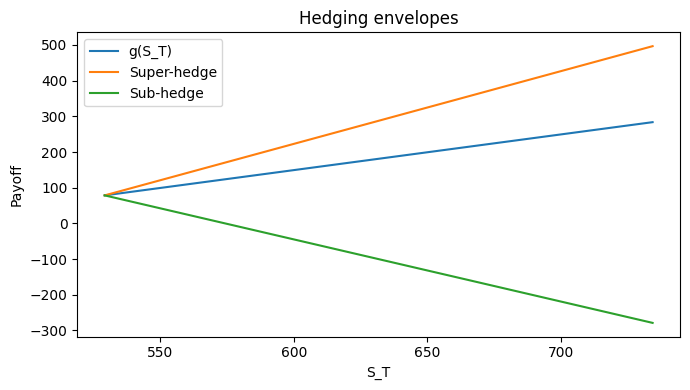

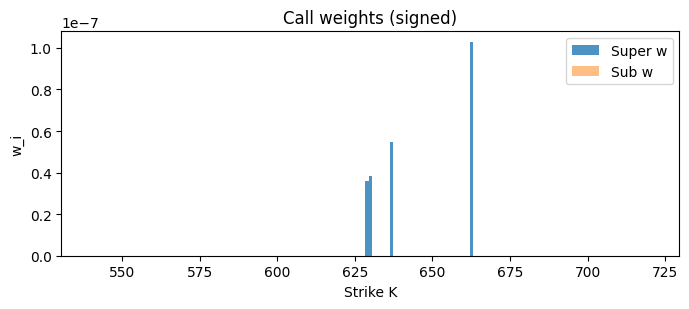

In [47]:
# ---- Plot ----
def replicate_curve(S, a,b,w, K):
    Phi = payoff_matrix(S,K)
    return a + b*S + Phi.dot(w)

import matplotlib.pyplot as plt
ghat_sup = replicate_curve(S, sup['a'], sup['b'], sup['w'], K)
ghat_sub = replicate_curve(S, sub['a'], sub['b'], sub['w'], K)

plt.figure(figsize=(7,4))
plt.plot(S, gS, label='g(S_T)')
plt.plot(S, ghat_sup, label='Super-hedge')
plt.plot(S, ghat_sub, label='Sub-hedge')
plt.title('Hedging envelopes'); plt.xlabel('S_T'); plt.ylabel('Payoff'); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(7,3.2))
width = (K[1]-K[0]) if len(K)>1 else 1.0
plt.bar(K, sup['w'], width=width, alpha=0.8, label='Super w')
plt.bar(K, sub['w'], width=width, alpha=0.5, label='Sub w')
plt.title('Call weights (signed)'); plt.xlabel('Strike K'); plt.ylabel('w_i'); plt.legend(); plt.tight_layout(); plt.show()

In [48]:
# ---- Save portfolios & summary ----
sup_path = DATA_DIR / 'bounds_super_weights.csv'
sub_path = DATA_DIR / 'bounds_sub_weights.csv'
summary_path = DATA_DIR / 'bounds_summary.json'

pd.DataFrame({'K':K, 'w_super': sup['w']}).to_csv(sup_path, index=False)
pd.DataFrame({'K':K, 'w_sub': sub['w']}).to_csv(sub_path, index=False)
with open(summary_path, 'w') as f:
    json.dump(dict(payoff=PAYOFF_NAME, params=PARAMS, F_T=float(F_T), D=float(D),
                   lower=float(sub['price']), upper=float(sup['price']),
                   width=float(sup['price']-sub['price']), source=str(SRC),
                   solver_super=sup['solver'], solver_sub=sub['solver']), f, indent=2)
print('Saved:', sup_path, summary_path)

Saved: C:\Pcs\Python\new price project\bounds_super_weights.csv C:\Pcs\Python\new price project\bounds_summary.json
